# 06 - SnakeCLEF - High-level Exploration of the Cleaned Training Dataset

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.core import data
from src.utils import visualization as viz


def plot_class_distribution(train_df, valid_df, *, title=None, ax=None):
    assert 'binomial' in train_df
    assert 'binomial' in valid_df

    if ax is None:
        fig, ax = viz.create_fig(ncols=1, nrows=1)

    train_df['binomial'].value_counts().plot(kind='area', label='Training Set', ax=ax)
    valid_df['binomial'].value_counts().plot(kind='area', label='Validation Set', ax=ax)
    ax.set(xticks=[], xlabel='Snake Species (classes)', ylabel='Image Counts', title=title)
    ax.legend()

    return ax


DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_cleaned.csv')
mini_train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv')
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

## General Statistics

**Number of samples in the full dataset:**

In [4]:
len(train_df)

374673

**Number of samples in the mini-subset:**

In [5]:
len(mini_train_df)

70440

**Targets:**

In [6]:
len(train_df['binomial'].unique())

770

In [7]:
len(train_df['genus'].unique())

267

In [8]:
len(train_df['family'].unique())

17

**Number of countries:**

In [9]:
len(train_df['country'].drop_duplicates())

188

**Geographical regions:**

In [10]:
geo_df = train_df[['UUID', 'continent', 'country']].copy()
cond = ((geo_df['continent'] == 'North America') &
        (~geo_df['country'].isin(['United States of America', 'Canada'])))
geo_df.loc[cond, 'continent'] = 'Middle America'

vc = geo_df['continent'].value_counts()
pd.concat([vc, vc/vc.sum()], axis=1)

,continent,continent
North America,258197,0.689126
unknown,42240,0.112738
Europe,17874,0.047706
Middle America,17193,0.045888
Asia,16111,0.043000
South America,12488,0.033330
Africa,5880,0.015694
Australia,4155,0.011090
Oceania,535,0.001428


**Data sources from which the dataset is made of:**

In [11]:
train_df['source'].value_counts()

inaturalist    276493
herpmapper      58239
flickr          39941
Name: source, dtype: int64

In [12]:
(train_df['source'].value_counts() / len(train_df)).round(3) * 100

inaturalist    73.8
herpmapper     15.5
flickr         10.7
Name: source, dtype: float64

**Data sources in geographical regions:**

In [13]:
train_df.groupby(['source', 'continent']).size()

source       continent    
flickr       Africa              296
             Asia               1249
             Australia           578
             Europe             1169
             North America      2663
             South America       503
             unknown           33483
herpmapper   Africa              395
             Asia               2143
             Europe              300
             North America     54278
             Oceania             535
             South America       587
             unknown               1
inaturalist  Africa             5189
             Asia              12719
             Australia          3577
             Europe            16405
             North America    218449
             South America     11398
             unknown            8756
dtype: int64

**Data sources with training validation split:**

In [14]:
train_df.groupby(['source', 'subset']).size()

source       subset
flickr       train      36018
             val         3923
herpmapper   train      52306
             val         5933
inaturalist  train     248880
             val        27613
dtype: int64

**List of countries with number of species with up to 30 samples:**

In [15]:
counts = train_df['binomial'].value_counts()
cond = train_df['binomial'].isin(counts[counts < 30].index)
train_df.loc[cond, 'country'].value_counts()

unknown         703
Mexico          449
South Africa    112
India           111
Australia       107
               ... 
Uruguay           1
Chad              1
France            1
Djibouti          1
Tunisia           1
Name: country, Length: 98, dtype: int64

**List of countries with number of species with at least 10,000 samples:**

In [16]:
counts = train_df['binomial'].value_counts()
cond = train_df['binomial'].isin(counts[counts >= 10_000].index)
train_df.loc[cond, 'country'].value_counts()

United States of America    78086
Canada                       6356
unknown                      2960
Mexico                       1086
Germany                         4
Spain                           3
Netherlands                     3
Singapore                       2
Belgium                         2
United Kingdom                  2
Honduras                        2
Sri Lanka                       1
Name: country, dtype: int64

## Class Distribution in the Mini Dataset (70k images)

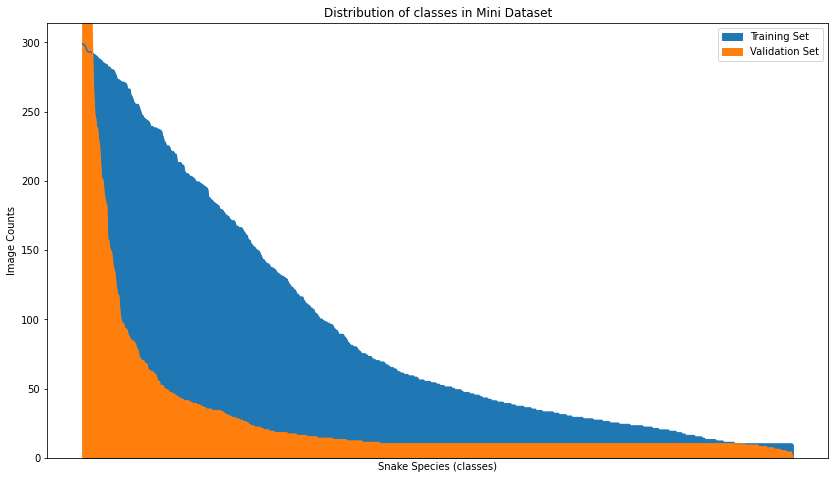

In [17]:
fig, ax = viz.create_fig(ncols=1, nrows=1, colsize=14, rowsize=8)
plot_class_distribution(mini_train_df, valid_df, title='Distribution of classes in Mini Dataset', ax=ax)
plt.show()

## Class Distribution in the Full Dataset (380k images)

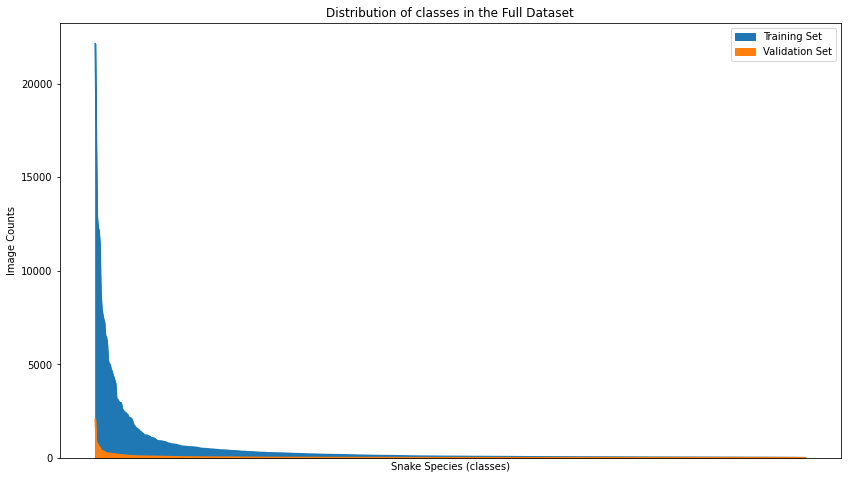

In [18]:
fig, ax = viz.create_fig(ncols=1, nrows=1, colsize=14, rowsize=8)
plot_class_distribution(train_df, valid_df, title='Distribution of classes in the Full Dataset', ax=ax)
plt.show()

## Show Image Examples

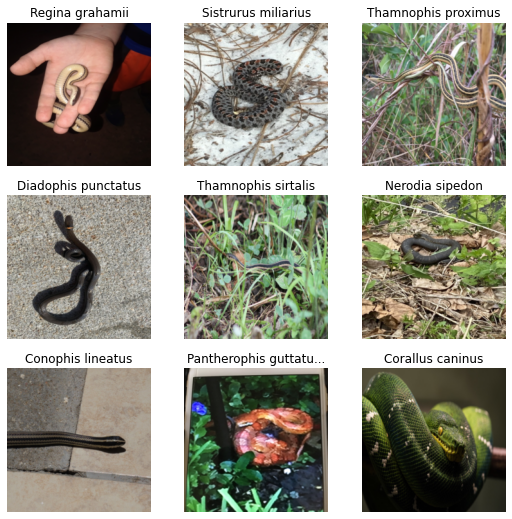

In [19]:
# create data loaders
trainloader = data.get_dataloader(
    train_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR)

trainloader.dataset.show_items()

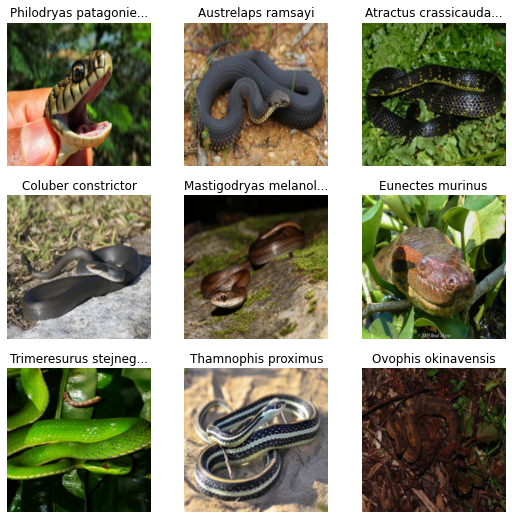

In [20]:
# create data loaders
validloader = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR)

validloader.dataset.show_items()

## Different Looking Snakes from the Same Species

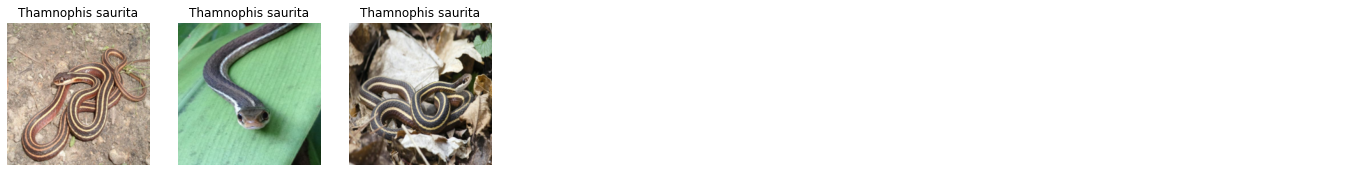

In [21]:
validloader.dataset.show_items([16829,  8061, 2692], ncols=8)  # Thamnophis saurita

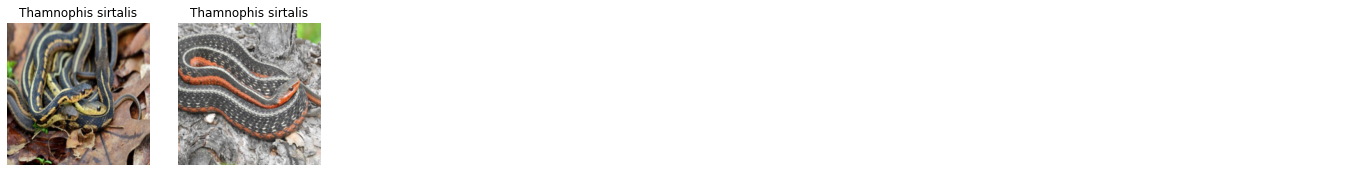

In [22]:
validloader.dataset.show_items([7587, 12319], ncols=8)  # Thamnophis sirtalis

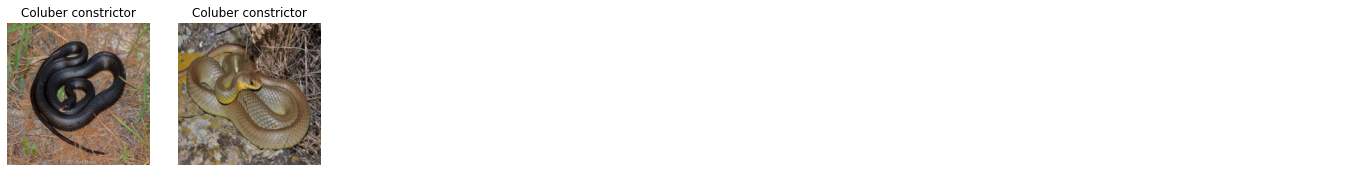

In [23]:
validloader.dataset.show_items([3600, 15617], ncols=8)  # 'Coluber constrictor'

In [24]:
import PIL

img, _ = validloader.dataset.get_item(3600)
img = img.resize((384, 384), resample=PIL.Image.BILINEAR)
img.save('figures/coluber_constrictor1.png', 'PNG')

img, _ = validloader.dataset.get_item(15617)
img = img.resize((384, 384), resample=PIL.Image.BILINEAR)
img.save('figures/coluber_constrictor2.png', 'PNG')

## Similarly Looking Snakes from Different Species

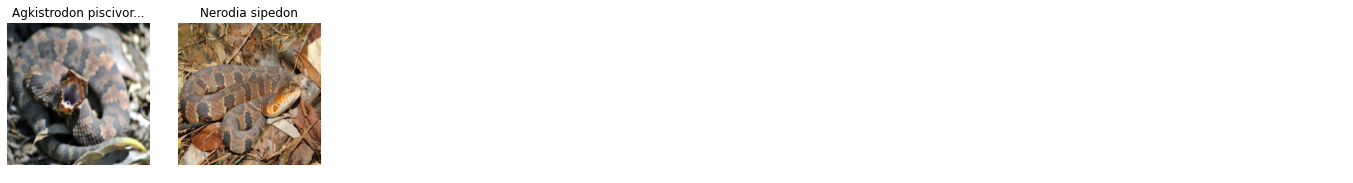

In [25]:
validloader.dataset.show_items([4279, 14449], ncols=8)  # 'Agkistrodon piscivorus', 'Nerodia sipedon'

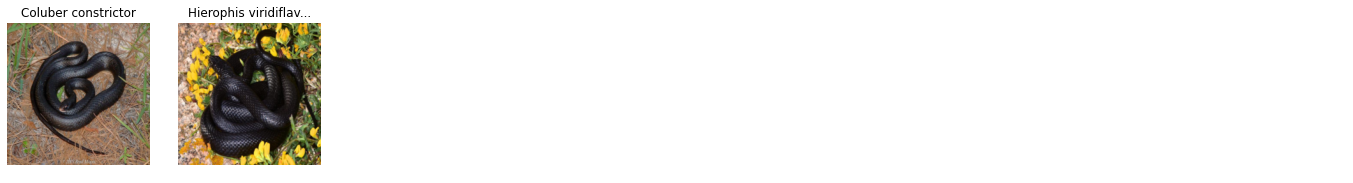

In [26]:
validloader.dataset.show_items([3600, 6198], ncols=8)  # 'Coluber constrictor', Bitis arietans

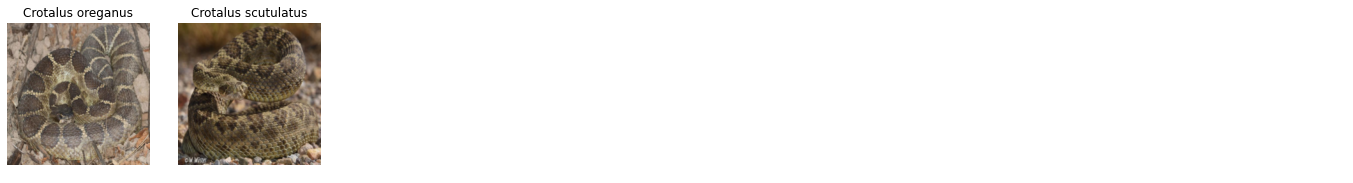

In [27]:
validloader.dataset.show_items([16736, 23500], ncols=8)  # 'Crotalus oreganus', Crotalus scutulatus

In [28]:
import PIL

img, _ = validloader.dataset.get_item(16736)
img = img.resize((384, 384), resample=PIL.Image.BILINEAR)
img.save('figures/crotalus_oreganus.png', 'PNG')

img, _ = validloader.dataset.get_item(23500)
img = img.resize((384, 384), resample=PIL.Image.BILINEAR)
img.save('figures/crotalus_scutulatus.png', 'PNG')